# Business Understanding

## Background

text

### Features

- **Net Downward Shortwave Radiation Flux [W/m^2]:** 
- **Wind Gust Surface [m/s]:** 
- **Planetary Boundary Layer Height [m]:** 
- **Mean Sea Level Pressure [pa]:** 
- **Potential Temperature Difference between 80m and 0m [K]:**
- **Specific Humidity in 2m height [1]:** 
- **Specific Humidity Mean over first 30 hPa (~250m) [1]:** 
- **Relative Humidity in 925 hPa pressure level [%]:** 
- **Relative Humidity in 950 hPa pressure level [%]:**
- **Net Sensible Heat Flux (conductive heat flux of the Earth surface to the atmosphere) [W/m^2]:**
- **Temperature in 100m height [K]:** 
- **Temperature in 2m height [K]:** 
- **Temperature Mean over first 30 hPa (~250m) [K]:** 
- **Total Cloud Cover, low level clouds (0km - 2km height) [%]:** 
- **Total Cloud Cover, mid level clouds (2km - 7km height) [%]:** 
- **Wind Direction in 100 m height [°]:** 
- **Wind Direction in 10 m height [°]:** 
- **Wind Direction Mean over first 30 hPa (~250m) [°]:** 
- **Wind Direction in 925 hPa pressure level [°]:** 
- **Wind Speed in 100 m height [m/s]:** 
- **Wind Speed in 10 m height [m/s]:** 
- **Wind Speed Mean over first 30 hPa (~250m) [°]:** 
- **Wind Speed in 925 hPa pressure level [°]:** 
- **Date and 24 Hours divided in quarters [?]:** 
- **Azimuth angle of the sun [°]:** 
- **Elevation angle of the sun [°]:** 

# Envoirment Set- Up

## Load relevant Python Packages

In [1]:
reset -fs

In [2]:
# Importing the most important modules and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle


# For Data Mining
import os, glob

# For Data Cleaning
from datetime import datetime
import missingno as msno

from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot
import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

<ipython-input-2-5484826bbdb6>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Global Variables and Settings

In [3]:
# Setting the random seed for reproducability
%matplotlib inline
plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

# Loading Datasets & First Cleaning

## GFS Data

In [4]:
# reading in the feature dataframe
with open('./data/griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_features = u.load()

In [5]:
print('First and last observations:')
pd.concat([df_features.head(2), df_features.tail(2)])

First and last observations:


,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_%,r_pl950_%,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_%,tccmedium_sfc_%,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00+00:00,0.0,16.777032,1349.927656,99212.06250,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,280.079346,280.496348,279.811816,99.375,49.50,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 07:00:00+00:00,0.0,16.606744,1352.623506,99259.81250,0.528755,0.005005,0.004739,89.250,82.250,-59.127808,279.950000,280.339922,279.664160,99.250,79.25,62.428351,59.839207,62.809819,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353
2019-08-26 17:00:00+00:00,217.0,6.996934,294.434175,101819.59375,0.721496,0.013280,0.011999,66.625,64.775,-17.322095,297.000000,297.050024,297.000000,0.000,0.00,253.352783,249.491241,254.108723,307.177015,6.489624,3.745793,6.426924,5.507465,2019-08-23 18:00:00+00:00,272.617737,12.060012
2019-08-26 18:00:00+00:00,79.5,8.050885,215.534009,101816.78750,1.798953,0.012720,0.011877,66.800,64.175,-38.183350,296.250000,294.969312,296.000000,0.000,0.00,250.512384,244.554716,251.835064,308.818931,7.496367,3.839874,7.413974,5.639764,2019-08-23 18:00:00+00:00,284.064789,2.764322


In [6]:
# rename columns which contains symbols
df_features = df_features.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})

## Quadra Data

In [7]:
# reading in the target dataframe
with open('./data/obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_target = u.load()

In [8]:
print('First and last observations:')
pd.concat([df_target.head(2), df_target.tail(2)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm
2018-01-01 00:00:00+01:00,0.330269,0.450934,0.120665
2018-01-01 00:10:00+01:00,0.339204,0.457539,0.118335
2019-06-25 01:40:00+02:00,0.308457,0.338645,0.030189
2019-06-25 01:50:00+02:00,0.309148,0.339853,0.030705


## Initial Observations

**Observations:**
- **Timezones:** The timezones in the datasets are inconsistent
- **Frequency**
    - **feature data:** hourly frequency
    - **target data:** 10minute frequency
- **DataFrames**: target and feature data are in two seperate DataFrames
- **Timeframe**
    - **feature data:** 1st Jan 2018 06:00 to 26th Aug 2019 18:00
    - **target data:** 1st Jan 2018 00:00  to 25th Jun 2019 01:50



**Resulting Steps**: 
- timezones: creating consistency of timezones
- frequency: resample feature data to have 10 minute frequency
- DataFrames: Merging Data into one DataFrame
- timeframes:reducing timeframes to have overlapping timeframes


# Data Cleaning

## Timezone

In [9]:
# converting to same timezone
df_features.index = df_features.index.tz_localize(None).to_series(keep_tz=True)

In [10]:
# converting to target data to the same timezone as the feature dataframe
df_target.index = df_target.index.tz_localize(None).to_series(keep_tz=True)

## Frequency

In [11]:
# resampling to a time range of 10 minutes and interpolate between the hourly values
df_features = df_features.resample('10min', axis='index').interpolate()

## Combining DataFrames

In [12]:
# combining both dataframes to have one to work in
df = pd.concat([df_target,df_features], axis=1)

In [13]:
df.iloc[34:38,:]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-01 05:40:00,0.361927,0.880949,0.519021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 05:50:00,0.364547,0.891657,0.527110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,NaN,113.717751,-10.743970


## Continuity Check

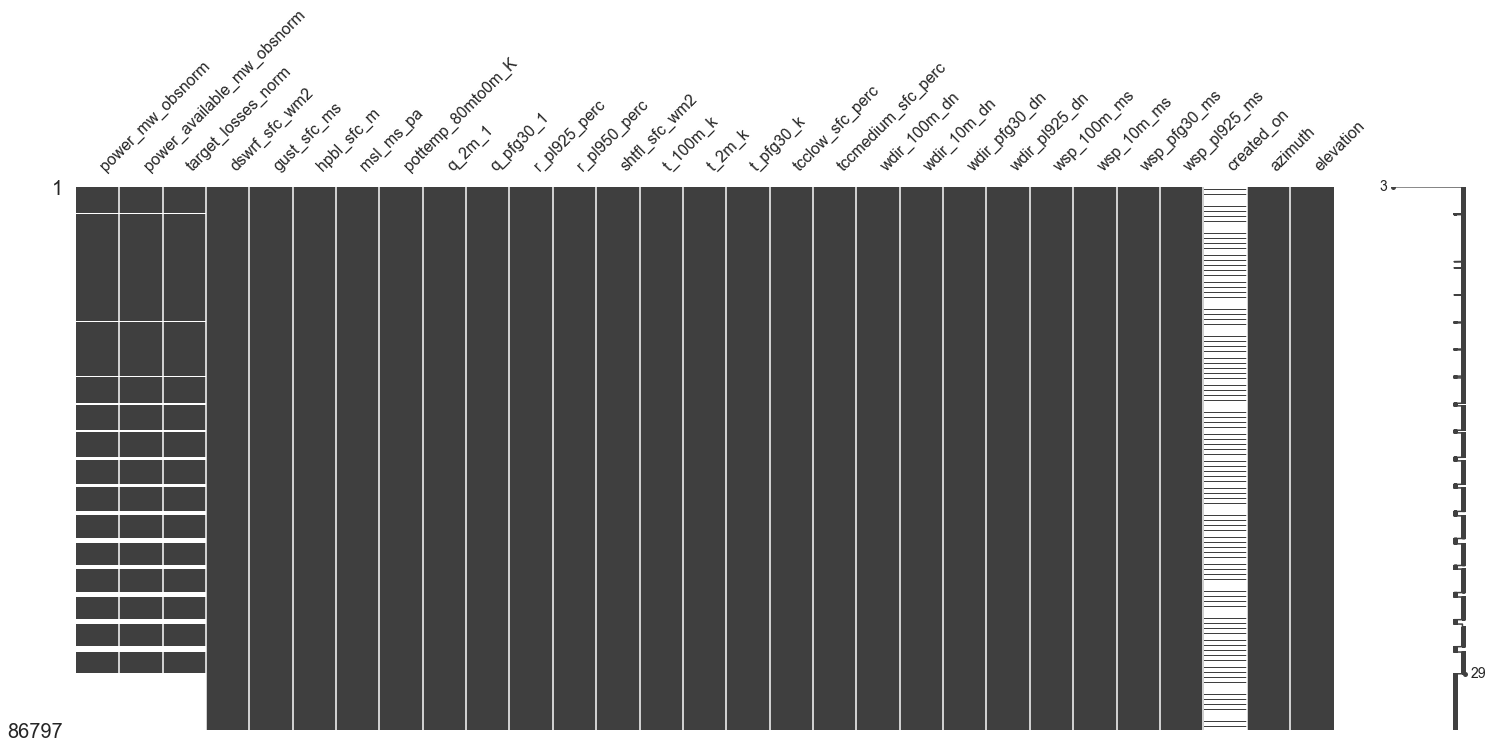

In [14]:
msno.matrix(df);

**Observations: **
- `created_on`: frequency interpolation did not work for TimeStamp data, columns will be dropped anyway. 
- target dataframe (first three coloumns): harmonisation of overall timeframe needed
- target data is uncontentious

In [15]:
# Percentage and Number of NaN-Values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
print()
print('MISSING VALUES (absolut and in percent)')
missing[missing.Number!=0].T


MISSING VALUES (absolut and in percent)


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
Number,16087.0,16087.0,16087.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,72419.0,36.0,36.0
Percentage,18.5,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.4,0.0,0.0


## Dropping Column "created_on"

In [16]:
df.drop(columns = ["created_on"], inplace = True)

## Timeframe harmonisation

In [17]:
end_index_str = "2019-06-25 01:50:00"
end_index = pd.to_datetime(end_index_str)

start_index_str = "2018-01-01 06:00:00"
start_index = pd.to_datetime(start_index_str)

print('Start Index of united DataFrame: ', start_index)
print('End Index of united DataFrame: ', end_index)

Start Index of united DataFrame:  2018-01-01 06:00:00
End Index of united DataFrame:  2019-06-25 01:50:00


In [18]:
df = df[(df.index <= end_index) & (df.index >= start_index)]
print('First and last observations:')
pd.concat([df.head(2), df.tail(2)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.075000,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.937500,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970
2019-06-25 01:40:00,0.308457,0.338645,0.030189,0.0,9.875370,224.096558,102141.404167,2.363946,0.009756,0.009464,49.275000,46.033333,-50.096021,291.646208,289.825765,291.759709,0.000000,0.000000,306.634403,295.683603,309.412828,343.164726,8.642075,4.004936,8.761264,9.492873,31.591799,-9.437372
2019-06-25 01:50:00,0.309148,0.339853,0.030705,0.0,9.713995,217.509660,102131.514583,2.370229,0.009704,0.009422,48.712500,45.616667,-49.312354,291.570260,289.732206,291.704854,0.000000,0.000000,306.528820,295.343899,309.409961,343.030446,8.607915,3.982537,8.720545,9.338253,33.775887,-8.668407


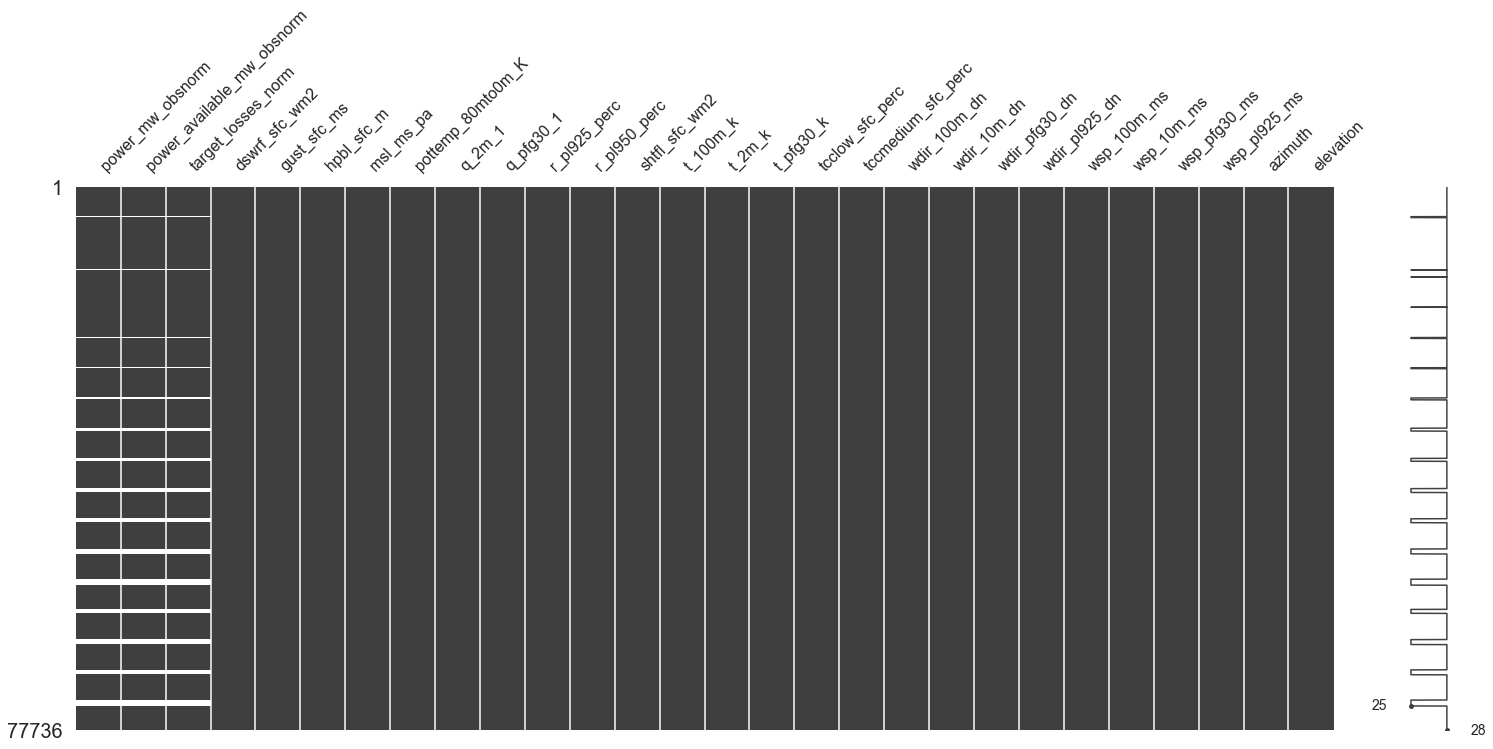

In [19]:
msno.matrix(df);

## Dealing with uncontentious target Data

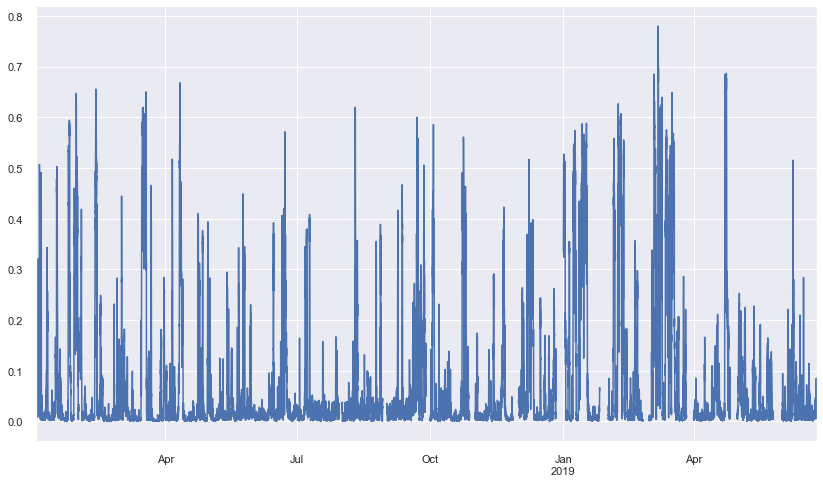

In [20]:
df.target_losses_norm.plot();

In [21]:
weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}

df['index1'] = df.index
df['Date'] = pd.to_datetime(df.index1.dt.date)
df['year'] = df.index1.dt.year
df['month'] = df.index1.dt.month
df['day'] = df.index1.dt.day
df['hour'] = df.index1.dt.hour
df['minute'] = df.index1.dt.minute
df['weekday'] = df.index1.dt.weekday.map(weekdays)
df['day_hour_minute'] = df.index1.dt.weekday + df['hour']*1/24 + (df['minute']//10 * 1/144)


df.drop(columns = ["index1"], inplace = True)
df.head(5)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,day_hour_minute
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,0.250000
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,0.256944
2018-01-01 06:20:00,0.500030,0.905168,0.405137,0.0,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,89.733333,82.8000,-58.672526,280.036230,280.444206,279.762598,99.333333,59.416667,57.112933,54.570948,57.507124,61.511338,16.630528,9.837206,16.692246,21.948260,115.554543,-9.355046,2018-01-01,2018,1,1,6,20,Monday,0.263889
2018-01-01 06:30:00,0.436176,0.918136,0.481961,0.0,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,89.612500,82.6625,-58.786346,280.014673,280.418135,279.737988,99.312500,64.375000,58.441787,55.888013,58.832798,62.785487,16.671646,9.869435,16.727331,21.940530,117.391335,-7.966123,2018-01-01,2018,1,1,6,30,Monday,0.270833
2018-01-01 06:40:00,0.423738,0.920801,0.497063,0.0,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,89.491667,82.5250,-58.900167,279.993115,280.392064,279.713379,99.291667,69.333333,59.770642,57.205077,60.158471,64.059635,16.712765,9.901665,16.762416,21.932800,119.228127,-6.577199,2018-01-01,2018,1,1,6,40,Monday,0.277778


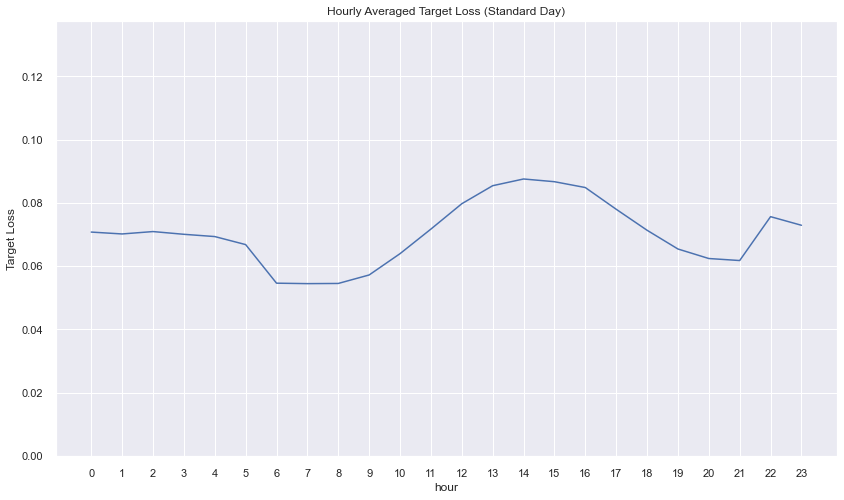

In [22]:
#Plotting average hourly load profile observed over the entire period 
df.groupby('hour')['target_losses_norm'].mean().plot(figsize = (14,8))
_ = plt.ylabel('Target Loss')
_ = plt.ylim([0, max(df.groupby('hour')['target_losses_norm'].mean()) + 0.05])
_ = plt.xticks(df['hour'].unique())
_ = plt.title('Hourly Averaged Target Loss (Standard Day)')

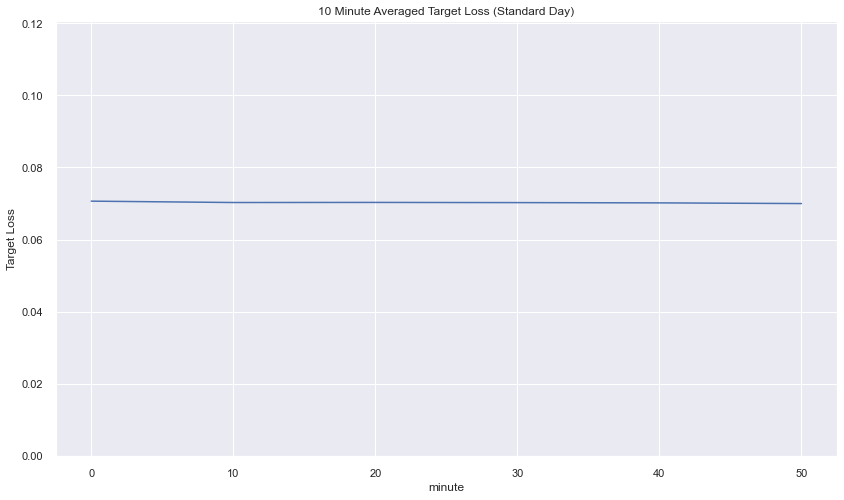

In [23]:
#Plotting 10 minute averaged target loss
df.groupby('minute')['target_losses_norm'].mean().plot(figsize = (14,8))
_ = plt.ylabel('Target Loss')
_ = plt.ylim([0, max(df.groupby('minute')['target_losses_norm'].mean()) + 0.05])
_ = plt.xticks(df['minute'].unique())
_ = plt.title('10 Minute Averaged Target Loss (Standard Day)')

In [24]:
# creating series objects with the different timestamps of a day and their corresponding mean values for target data
day_hour_minute_means_loss = df.groupby('day_hour_minute')['target_losses_norm'].mean().reset_index()
day_hour_minute_means_available = df.groupby('day_hour_minute')['power_available_mw_obsnorm'].mean().reset_index()
day_hour_minute_means_cons = df.groupby('day_hour_minute')['power_mw_obsnorm'].mean().reset_index()

# creating dictionaries to map the mean values to the according timestamps
day_hour_minute_means_loss_dict = dict(zip(day_hour_minute_means_loss.day_hour_minute, day_hour_minute_means_loss.target_losses_norm))
day_hour_minute_means_available_dict = dict(zip(day_hour_minute_means_available.day_hour_minute, day_hour_minute_means_available.power_available_mw_obsnorm))
day_hour_minute_means_cons_dict = dict(zip(day_hour_minute_means_cons.day_hour_minute, day_hour_minute_means_cons.power_mw_obsnorm))

# mapping the mean values to the according timestamps
df["mean_losses"] = df["day_hour_minute"].map(day_hour_minute_means_loss_dict)
df["mean_available"] = df["day_hour_minute"].map(day_hour_minute_means_available_dict)
df["mean_cons"] = df["day_hour_minute"].map(day_hour_minute_means_cons_dict)

# filling in the nan values in our target data with the mean value for the corresponding timestamp on the day
df["target_losses_norm"].fillna(df["mean_losses"], inplace=True)
df["power_available_mw_obsnorm"].fillna(df["mean_losses"], inplace=True)
df["power_mw_obsnorm"].fillna(df["mean_losses"], inplace=True)

# dropping the columns with the mean values again
df.drop(columns = ["mean_losses", "mean_available", "mean_cons", "day_hour_minute"], inplace = True)

df.head()


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday
2018-01-01 06:20:00,0.500030,0.905168,0.405137,0.0,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,89.733333,82.8000,-58.672526,280.036230,280.444206,279.762598,99.333333,59.416667,57.112933,54.570948,57.507124,61.511338,16.630528,9.837206,16.692246,21.948260,115.554543,-9.355046,2018-01-01,2018,1,1,6,20,Monday
2018-01-01 06:30:00,0.436176,0.918136,0.481961,0.0,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,89.612500,82.6625,-58.786346,280.014673,280.418135,279.737988,99.312500,64.375000,58.441787,55.888013,58.832798,62.785487,16.671646,9.869435,16.727331,21.940530,117.391335,-7.966123,2018-01-01,2018,1,1,6,30,Monday
2018-01-01 06:40:00,0.423738,0.920801,0.497063,0.0,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,89.491667,82.5250,-58.900167,279.993115,280.392064,279.713379,99.291667,69.333333,59.770642,57.205077,60.158471,64.059635,16.712765,9.901665,16.762416,21.932800,119.228127,-6.577199,2018-01-01,2018,1,1,6,40,Monday


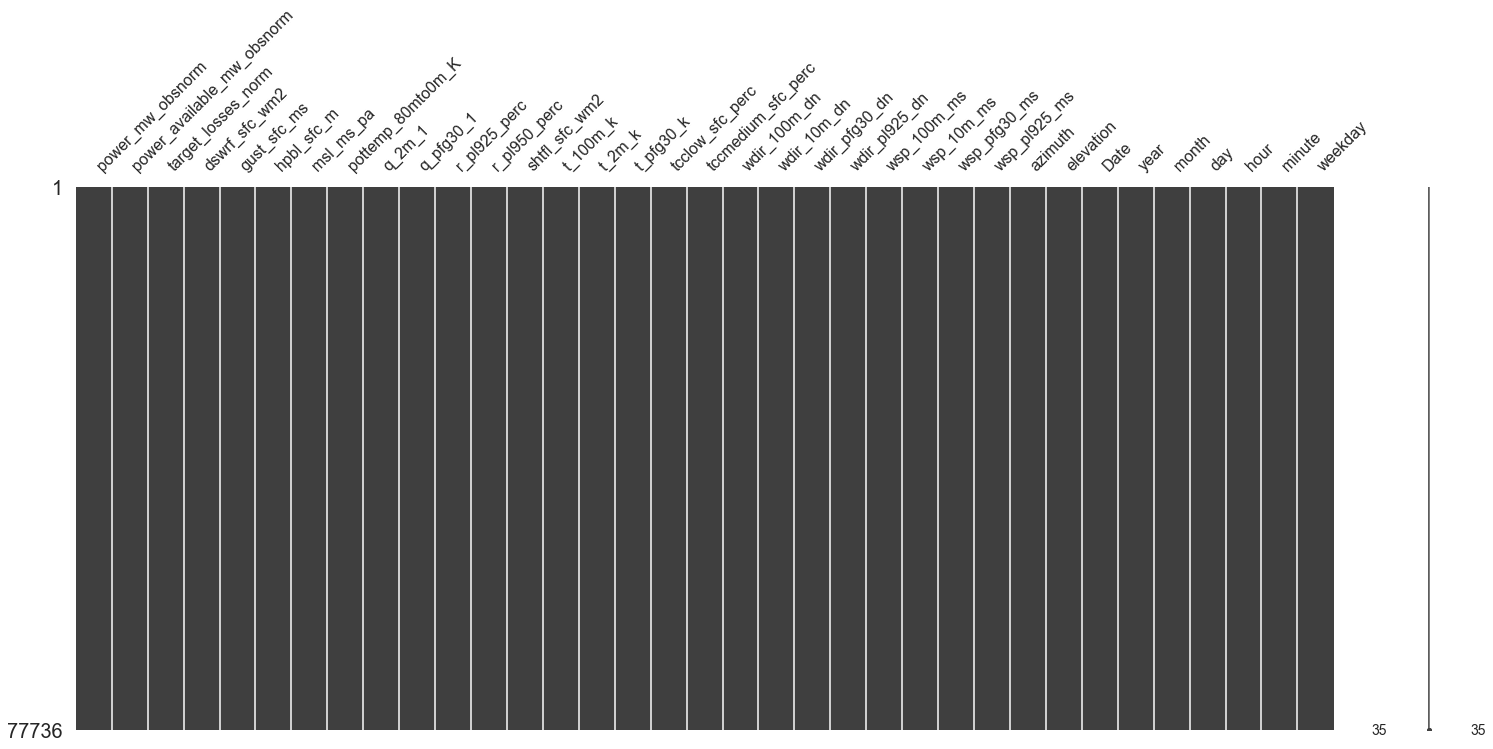

In [25]:
msno.matrix(df);

In [26]:
# Percentage and Number of NaN-Values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
print()
print('MISSING VALUES (absolut and in percent)')
missing[missing.Number!=0].T


MISSING VALUES (absolut and in percent)


""
Number
Percentage


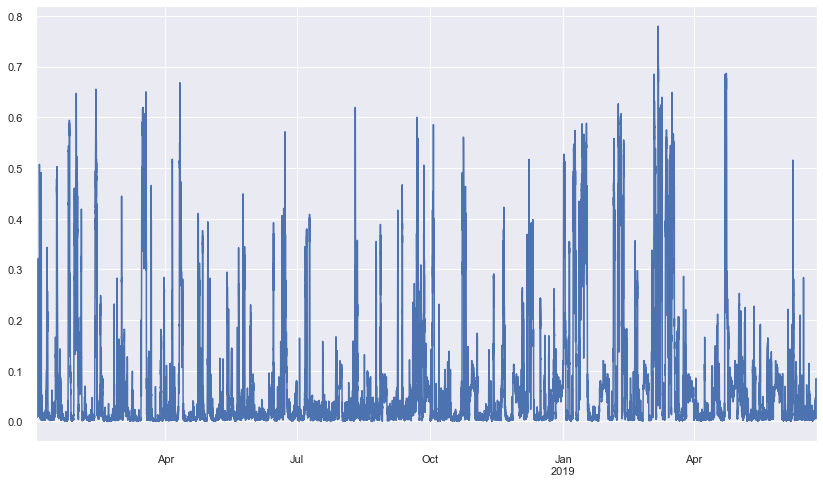

In [27]:
df.target_losses_norm.plot();

# Seasonality Analysis

In [28]:
#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell will contain the average
#energy consumption for that particular hour of the weekday

hour_weekday = df.pivot_table(values='target_losses_norm', index='hour', columns = 'weekday', aggfunc = 'mean')
columns = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
hour_weekday = hour_weekday[columns]

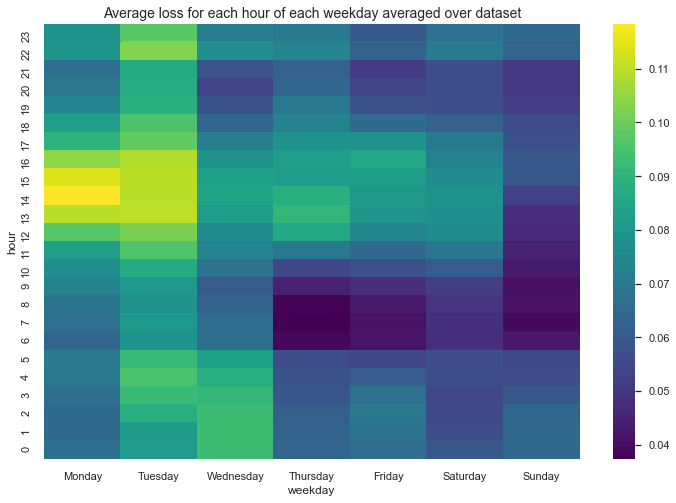

In [29]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
#_ = plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')
_ = ax.set_title("Average loss for each hour of each weekday averaged over dataset", fontsize = 14)


In [30]:
#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell will contain the average
#energy consumption for that particular hour of the weekday

hour_weekday_consumed = df.pivot_table(values='power_mw_obsnorm', index='hour', columns = 'weekday', aggfunc = 'mean')
columns = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
hour_weekday_consumed = hour_weekday[columns]


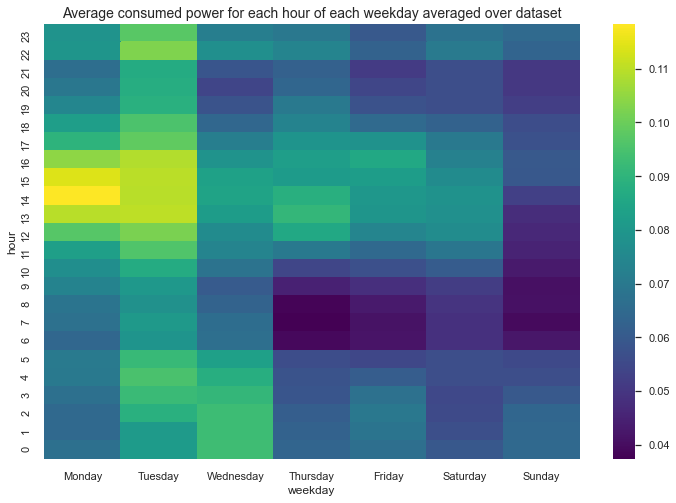

In [35]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday_consumed.sort_index(ascending = False), cmap='viridis')
#_ = plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')
_ = ax.set_title("Average consumed power for each hour of each weekday averaged over dataset", fontsize = 14)


Observations: 
- consumed power is not representative for the overall power consumption of the local grid, but rather for the amount of wind power fed into the grid (normed on the maximum available power = installed power)

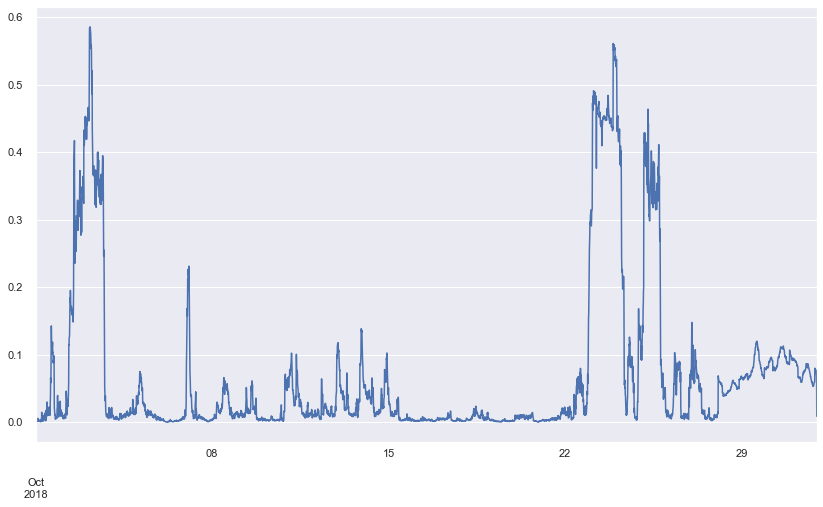

In [36]:
df[df["month"] == 10]["target_losses_norm"].plot();

## Adding column working day

Since the energy consumption in the grid might be correlated to the day being a working or non working day, a feature called working day is implemented. All the weekend days and the national holidays for Germany will be categorized as non-working days.

In [37]:
#! pip install workalendar
from workalendar.europe import Germany
cal = Germany()
df["working_day"] = df["Date"].apply(lambda x: cal.is_working_day(x))
df.head()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,working_day
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,False
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,False
2018-01-01 06:20:00,0.500030,0.905168,0.405137,0.0,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,89.733333,82.8000,-58.672526,280.036230,280.444206,279.762598,99.333333,59.416667,57.112933,54.570948,57.507124,61.511338,16.630528,9.837206,16.692246,21.948260,115.554543,-9.355046,2018-01-01,2018,1,1,6,20,Monday,False
2018-01-01 06:30:00,0.436176,0.918136,0.481961,0.0,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,89.612500,82.6625,-58.786346,280.014673,280.418135,279.737988,99.312500,64.375000,58.441787,55.888013,58.832798,62.785487,16.671646,9.869435,16.727331,21.940530,117.391335,-7.966123,2018-01-01,2018,1,1,6,30,Monday,False
2018-01-01 06:40:00,0.423738,0.920801,0.497063,0.0,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,89.491667,82.5250,-58.900167,279.993115,280.392064,279.713379,99.291667,69.333333,59.770642,57.205077,60.158471,64.059635,16.712765,9.901665,16.762416,21.932800,119.228127,-6.577199,2018-01-01,2018,1,1,6,40,Monday,False


## Checking for duplicate timestamps

In [38]:
np.any(df.index.duplicated())

False

There are no duplicate timestamps in the dataframe.

## Adding column season

Since the location of our wind farm is in northern Germany we will apply a filter on our dataset that separates the dates into two basic seasons (summer and winter). As the summer in northern Germany tends to be shorter, only the months from May to August will be declared summer months.

In [39]:
def season_calc(month):
    if month in [5,6,7,8]:
        return 1 #"summer"
    else:
        return 0 #"winter"
    
df['summer'] = df.Date.dt.month.apply(season_calc)
df.head()

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,working_day,summer
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,False,0
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,False,0
2018-01-01 06:20:00,0.500030,0.905168,0.405137,0.0,16.720270,1350.826273,99227.979167,0.549156,0.005072,0.004815,89.733333,82.8000,-58.672526,280.036230,280.444206,279.762598,99.333333,59.416667,57.112933,54.570948,57.507124,61.511338,16.630528,9.837206,16.692246,21.948260,115.554543,-9.355046,2018-01-01,2018,1,1,6,20,Monday,False,0
2018-01-01 06:30:00,0.436176,0.918136,0.481961,0.0,16.691888,1351.275581,99235.937500,0.544055,0.005055,0.004796,89.612500,82.6625,-58.786346,280.014673,280.418135,279.737988,99.312500,64.375000,58.441787,55.888013,58.832798,62.785487,16.671646,9.869435,16.727331,21.940530,117.391335,-7.966123,2018-01-01,2018,1,1,6,30,Monday,False,0
2018-01-01 06:40:00,0.423738,0.920801,0.497063,0.0,16.663507,1351.724889,99243.895833,0.538955,0.005038,0.004777,89.491667,82.5250,-58.900167,279.993115,280.392064,279.713379,99.291667,69.333333,59.770642,57.205077,60.158471,64.059635,16.712765,9.901665,16.762416,21.932800,119.228127,-6.577199,2018-01-01,2018,1,1,6,40,Monday,False,0
